In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Star's subdomains

In [2]:
# Triangle vertices
r1 = np.array([0, 0])
r2 = np.array([2.8, .3])
r3 = np.array([2, 2.71828])

# Midle of sides
r12 = 0.5 * (r1 + r2)
r13 = 0.5 * (r1 + r3)
r23 = 0.5 * (r2 + r3)

# The center of circle
rc = (r1 + r2 + r3) / 3.

s1 = np.array([r1, r12, rc, r13])
s2 = np.array([r12, r2, r23, rc])
s3 = np.array([rc, r23, r3, r13])

domain = [s1, s2, s3]

## Draw domain

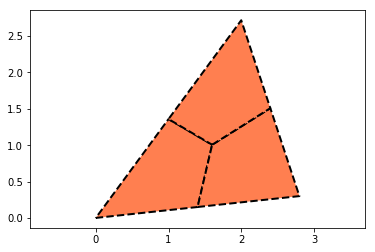

In [3]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

patches = []
for s in domain:
    polygon = Polygon(s, True)
    patches.append(polygon)
   
p = PatchCollection(patches, color="coral", edgecolor='k', lw=2, linestyle="dashed")
plt.axes().add_collection(p)

plt.axis("equal")
plt.show()

# Generate stifness matrices and force vectors on the subdomains

## Build mesh container which maps each subdomain on a quad $K = [-1, 1]^2$

In [4]:
d = 6 # Each grid for subdomains s1, s2, s3, s4, s5 will contains 4**d nodes

In [5]:
from qtt_laplace.basis.quad_mesh_container import QuadMeshContainer

def get_mesh_containers(domain, d):
    mc = []
    for s in domain:
        mc.append(QuadMeshContainer(s[0], s[1], s[2], s[3], d))
    
    return mc

In [6]:
mesh_containers = get_mesh_containers(domain, d)

# Build a stiffness matrix and a force vector on each subdomain 

We use Laplace shape functions fo basis.

In [7]:
from qtt_laplace.basis.linear_basis.phy2d import LinearPhi2D
from qtt_laplace.generate_mesh import assemble_on_quad

def get_stissness_and_force(mesh_containers, basis_function):
    sf = []
    for mc in mesh_containers:
        sf.append(assemble_on_quad(mc, basis_function))
    
    return sf

In [8]:
sf = get_stissness_and_force(mesh_containers, LinearPhi2D)

# Apply boundary conditions
## Generate mask
Our figure is simmetrical, that why we have the same mash for each subdomain

In [9]:
from qtt_laplace.basis.boundary_condition import gen_mask, apply_mask

In [10]:
xc = ['D', 'N']
yc = ['D', 'N']
mask1 = gen_mask(xc, yc, d)

xc = ['N', 'D']
yc = ['D', 'N']
mask2 = gen_mask(xc, yc, d)

xc = ['N', 'D']
yc = ['N', 'D']
mask3 = gen_mask(xc, yc, d)

## Apply mask to each subdomain

In [11]:
def apply_masks(sf, masks):
    sf_applied = []
    for (A, f), mask in zip(sf, masks):
        sf_applied.append(apply_mask(A, f, mask))
        
    return sf_applied

In [12]:
sf_applied = apply_masks(sf, [mask1, mask2, mask3])

## Draw result for validation

In [13]:
import tt
from tt.amen import amen_solve
from qtt_laplace.zoperations import zkronv
from scipy.spatial import Delaunay

def plt_patch(patch, x, px, py, borders, vmin=0, vmax=1, contours=True):
    pts = np.array([patch._pts(ex, ey) for ex, ey in zip(px, py)])
    tri = Delaunay(pts)
    result = plt.tripcolor(pts[:,0], pts[:,1], tri.simplices.copy(), x, shading='gouraud', vmin=vmin, vmax=vmax)
    if contours:
        result = plt.tricontour(pts[:,0], pts[:,1], tri.simplices.copy(), x, np.linspace(vmin, vmax, 11), colors='k')
    n = pts.shape[0] - 1
    d = patch.d
    p1 = patch._pts(0, 0)
    p2 = patch._pts(2**d-1, 0)
    p3 = patch._pts(2**d-1, 2**d-1)
    p4 = patch._pts(0, 2**d-1)
    
    if borders:
        return plt.plot([p1[0], p2[0], p3[0], p4[0]], \
                     [p1[1], p2[1], p3[1], p4[1]], 'm')
    else:
        return result

def draw_solution_on_path(result, mc, d, borders=True, tt_format=True):
    if tt_format:
        X = result.full().reshape([4**d], order='F')
    else:
        X = result
    
    px = zkronv(tt.xfun(2, d), tt.ones(2, d)) 
    py = zkronv(tt.ones(2, d), tt.xfun(2, d))
    px = px.full().flatten('F').astype(np.int)
    py = py.full().flatten('F').astype(np.int)

    vmax = np.max(X)
    return plt_patch(mc, X, px, py, vmax=vmax, contours=False, borders=borders)

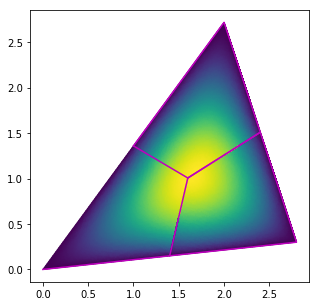

In [14]:
plt.figure(figsize=(5, 5))

for (A_app, f_app), mc in zip(sf_applied, mesh_containers):
    answer = amen_solve(A_app, f_app, f_app, 1e-8)
    _ = draw_solution_on_path(answer, mc, d, borders=True)

plt.axis('equal')
plt.show()

As you can see, the solution isn't smooth enought. It's because we haven't concatenate solution one to each other.

# Subdomains concatenation

## Annotate patches

In [15]:
def annotate_patch(patch, ax, title): 
    d = patch.d 
    p1 = patch._pts(0, 0) 
    p2 = patch._pts(2**d-1, 0) 
    p3 = patch._pts(2**d-1, 2**d-1) 
    p4 = patch._pts(0, 2**d-1) 
    patch_points = np.array([p1, p2, p3, p4, p1]) 
    ax.plot(patch_points[:, 0], patch_points[:, 1], 'k') 
    ax.annotate('BOTTOM', (p1+p2)/2) 
    ax.annotate('RIGHT', (p2+p3)/2) 
    ax.annotate('TOP', (p3+p4)/2) 
    ax.annotate('LEFT', (p4+p1)/2) 

    ax.annotate('LLC', p1) 
    ax.annotate('LRC', p2) 
    ax.annotate('URC', p3) 
    ax.annotate('ULC', p4)
    ax.set_title(title)
    ax.axis('equal')

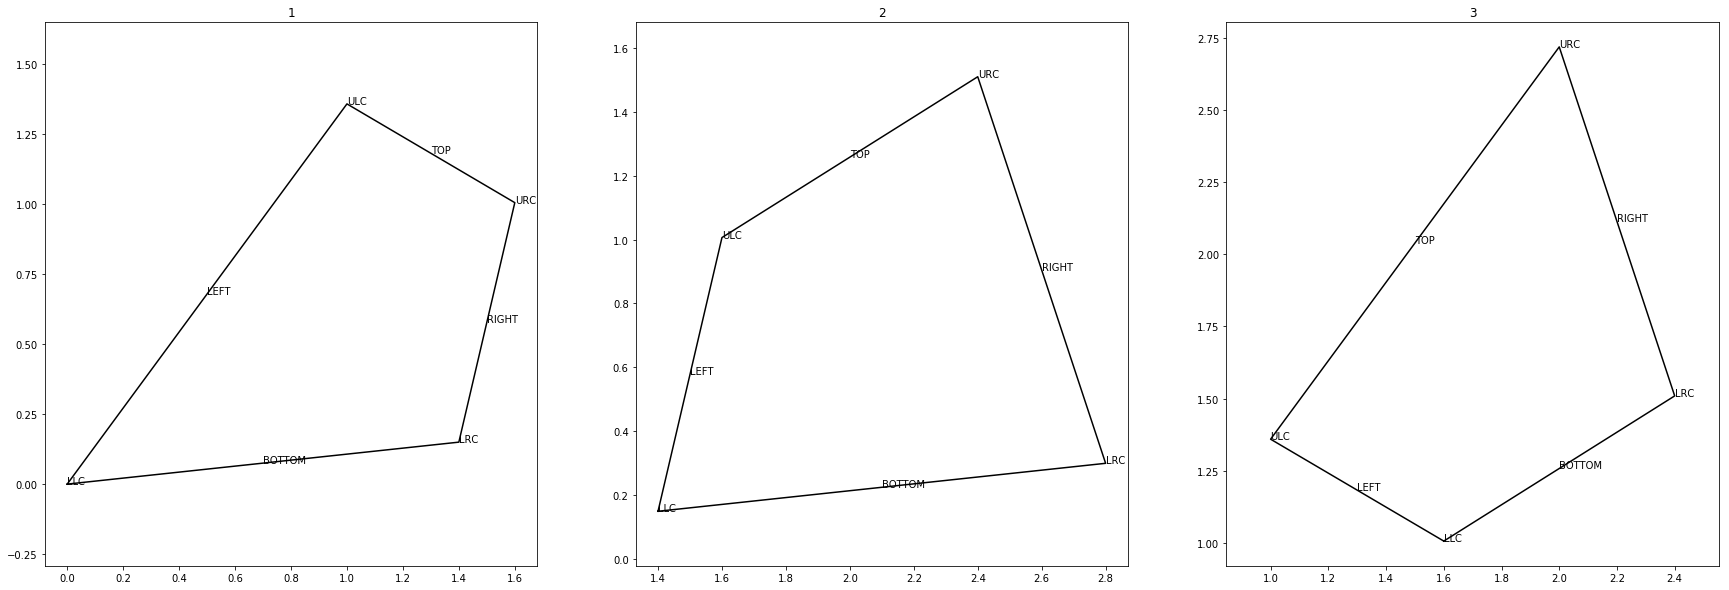

In [16]:
f, axarr = plt.subplots(1, 3, figsize=(30, 10))
annotate_patch(mesh_containers[0], axarr[0], "1")
annotate_patch(mesh_containers[1], axarr[1], "2")
annotate_patch(mesh_containers[2], axarr[2], "3")

All subdomains concatenate along bottom side and left side (1 concatenates the bottom side with the left side of second, etc).

## Concatenate subdomains

### Concatenate one to each other

In [17]:
from qtt_laplace.generate_interfaces import *
from qtt_laplace.zoperations import zkronv

import itertools

def construct_submatrices(sf_applied, d):
    A = []
    S = []
    F = []
    G = []
    
    n = len(sf_applied)
    for i, (a, f) in enumerate(sf_applied):
        A.append(a)
        F.append(f)
        G.append(f.copy())
        
        S_row = [0*tt.eye(4, d) for _ in range(n)]
        S_row[i] = a.copy()
        S.append(S_row)
    
    return A, S, F, G

def concatenate_subdomains(A11, A22, f1, f2, B11, B12, B21, B22, g1, g2, side_1, side_2, d, l = 0.5):
    P12, P21, P11, P22 = getP(d, side_1, side_2)
    B12 = P12 * A22 - l * P12
    B21 = P21 * A11 - l * P21
    B11 = B11 - l * P11
    B22 = B22 - l * P22
    g1 = g1 + tt.matvec(P12, f2)
    g2 = g2 + tt.matvec(P21, f1)
    
    return B11, B12, B21, B22, g1, g2

In [18]:
A, B, F, G = construct_submatrices(sf_applied, d)

In [19]:
B[0][0], B[0][1], B[1][0], B[1][1], G[0], G[1] = concatenate_subdomains(A[0], A[1], F[0], F[1],
                                                                        B[0][0], B[0][1], B[1][0], B[1][1], 
                                                                        G[0], G[1], 'RIGHT', 'LEFT', d)
B[1][1], B[1][2], B[2][1], B[2][2], G[1], G[2] = concatenate_subdomains(A[1], A[2], F[1], F[2],
                                                                        B[1][1], B[1][2], B[2][1], B[2][2], 
                                                                        G[1], G[2], 'TOP', 'BOTTOM', d)
B[2][2], B[2][0], B[0][2], B[0][0], G[2], G[0] = concatenate_subdomains(A[2], A[0], F[2], F[0],
                                                                        B[2][2], B[2][0], B[0][2], B[0][0], 
                                                                        G[2], G[0], 'LEFT', 'TOP', d) 

### Build the final stiffness matrix and the force vector

In [20]:
def pack_to_arrays(B, f, g):
    d = len(g)
    
    BBB = np.empty([d, d], dtype=object)
    for i, j in itertools.product(range(d), repeat=2):
        BBB[i, j] = B[i][j]
        
    fff = np.empty(d, dtype=object)
    ggg = np.empty(d, dtype=object)    
    
    for i in range(d):
        fff[i] = f[i]
        ggg[i] = g[i]
        
    return BBB, fff, ggg

def build_final_sriffness_and_force(BBB, fff, ggg, eps):
    d = BBB.shape[0]
    
    S = None
    F = None
    G = None
    
    for i in range(d):
        for j in range(d):
            Iij = np.zeros([d, d])
            Iij[i,j] = 1
            Iij = tt.matrix(Iij)
            if S is None:
                S = tt.kron(BBB[i,j], Iij)
            else:
                S = S + tt.kron(BBB[i,j], Iij)
            S = S.round(eps)
            
        Ii = np.zeros(d)
        Ii[i] = 1
        Ii = tt.vector(Ii)            
        if F is None:
            F = tt.kron(ggg[i], Ii)
        else:
            F = F + tt.kron(ggg[i], Ii)
        
        if G is None:
            G = tt.kron(fff[i], Ii)
        else:
            G = G + tt.kron(fff[i], Ii)

        F = F.round(eps)
        G = G.round(eps)
    
    return S, F, G

In [21]:
eps = 1e-8

In [22]:
BBB, fff, ggg = pack_to_arrays(B, F, G)
S, F, G = build_final_sriffness_and_force(BBB, fff, ggg, eps=eps*0.01)

# Find the solution on star

In [23]:
answer = amen_solve(S, F, F, eps)
energy = tt.sum(answer*G)

# Plot solution

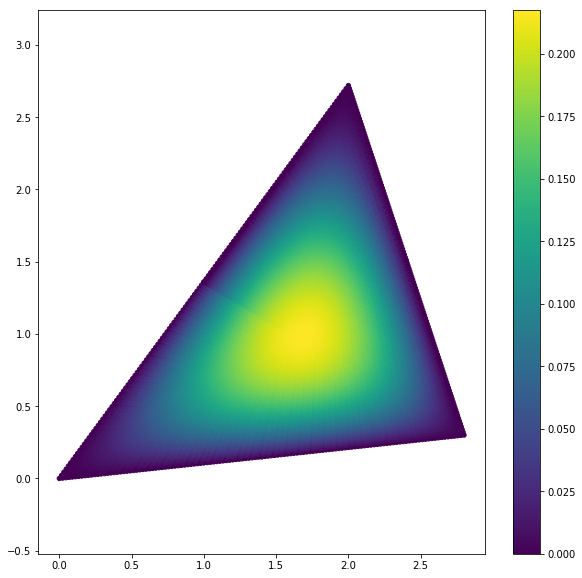

In [24]:
l = len(mesh_containers)


x = answer.full().reshape([l*4**d], order='F')

px = zkronv(tt.xfun(2, d), tt.ones(2, d)).full().flatten('F').astype(np.int)
py = zkronv(tt.ones(2, d), tt.xfun(2, d)).full().flatten('F').astype(np.int)

pts = []
for patch in mesh_containers:
    pts += [patch._pts(ex, ey) for ex, ey in zip(px, py)]
pts = np.array(pts)

plt.figure(figsize=(10, 10))
plt.scatter(pts[:,0], pts[:,1], c = x, marker='.', s=75)
plt.colorbar()
plt.axis('equal')
plt.show()

Smooth neat solution. The "line" on the left side caused by double drawing solution on the border. One time at each subdomain.

# Check convergence to the real value
We will compare result with FEniCS.

In [28]:
FENICS_BENCH_FILE = "triangle_energy.txt"
TT_BENCH_FILE = "triangle_tt_energy.txt"

In [27]:
from dolfin import *
from mshr import *
from pylab import show, triplot

def get_solution_energy(u):
    s = inner(grad(u), grad(u))*dx
    return assemble(s)
    
def solve_equation(mesh):
    def boundary(x, on_boundary):
        return on_boundary
    
    V = FunctionSpace(mesh, "Lagrange", 1)
    

    u0 = Constant(0.0)
    bc = DirichletBC(V, u0, boundary)
    

    u = TrialFunction(V)
    v = TestFunction(V)
    f = Expression("1", degree=2)
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx

    u = Function(V)
    
    solve(a == L, u, bc)
    
    energy = get_solution_energy(u)
    return energy

def get_star_domain(subdomains, resolution):
    domain = None
    for subdomain in subdomains:
        d = [Point(q[0], q[1]) for q in subdomain]
        if domain is None:
            domain = Polygon(d)
        else:
            domain += Polygon(d)
    mesh = generate_mesh(domain, resolution)    
    return mesh

def get_statistics(mesh):
    plt.title("Star mesh")
    coords = mesh.coordinates()
    triplot(coords[:,0], coords[:,1], triangles=mesh.cells())
    print("Finite elements:", mesh.num_cells())
    print("Vertices:", mesh.num_vertices())
    plt.axis('equal')
    show()

In [28]:
fenics_v = []
fenics_e = []

with open(FENICS_BENCH_FILE, "w") as f:
    for resolution in np.arange(100, 1000, 20.0):
        mesh = get_star_domain(domain, float(resolution))
        energy = solve_equation(mesh)
        fenics_v.append(mesh.num_vertices())
        fenics_e.append(energy)

        f.write("%i\t%.20f\n"%(mesh.num_vertices(), energy))
        f.flush()
        if resolution % 100 == 0:
            print(resolution)

100.0
200.0
300.0
400.0
500.0
600.0
700.0
800.0
900.0


And now do a series of expirements with QTT

In [32]:
import sys

D = [2, 3, 4, 5, 6, 7, 8, 9]
epss = [1e-8]

xc = ['N', 'D']
yc = ['N', 'D']

tt_vertices = []
tt_energy = []
with open(TT_BENCH_FILE, "w") as f_out:
    for eps in epss:
        for d in D:
            print >> sys.stderr, "d:", d, "eps:", eps
            
            mesh_containers = get_mesh_containers(domain, d)
            sf = get_stissness_and_force(mesh_containers, LinearPhi2D)
            
            xc = ['D', 'N']
            yc = ['D', 'N']
            mask1 = gen_mask(xc, yc, d)

            xc = ['N', 'D']
            yc = ['D', 'N']
            mask2 = gen_mask(xc, yc, d)

            xc = ['N', 'D']
            yc = ['N', 'D']
            mask3 = gen_mask(xc, yc, d)
            
            sf_applied = apply_masks(sf, [mask1, mask2, mask3])

            A, B, F, G = construct_submatrices(sf_applied, d)

            B[0][0], B[0][1], B[1][0], B[1][1], G[0], G[1] = concatenate_subdomains(A[0], A[1], F[0], F[1],
                                                                                    B[0][0], B[0][1], B[1][0], B[1][1], 
                                                                                    G[0], G[1], 'RIGHT', 'LEFT', d)
            B[1][1], B[1][2], B[2][1], B[2][2], G[1], G[2] = concatenate_subdomains(A[1], A[2], F[1], F[2],
                                                                                    B[1][1], B[1][2], B[2][1], B[2][2], 
                                                                                    G[1], G[2], 'TOP', 'BOTTOM', d)
            B[2][2], B[2][0], B[0][2], B[0][0], G[2], G[0] = concatenate_subdomains(A[2], A[0], F[2], F[0],
                                                                                    B[2][2], B[2][0], B[0][2], B[0][0], 
                                                                                    G[2], G[0], 'LEFT', 'TOP', d)  

            BBB, fff, ggg = pack_to_arrays(B, F, G)
            S, F, G = build_final_sriffness_and_force(BBB, fff, ggg, eps=eps*0.01)

            answer = amen_solve(S, F, F, eps)
            energy = tt.sum(answer*G)
            vertices = 3*4**d
            
            tt_vertices.append(vertices)
            tt_energy.append(energy)
            
            f_out.write("%d\t%.20f\n"%(vertices, energy))

d: 2 eps: 1e-08
d: 3 eps: 1e-08
d: 4 eps: 1e-08
d: 5 eps: 1e-08
d: 6 eps: 1e-08
d: 7 eps: 1e-08
d: 8 eps: 1e-08
d: 9 eps: 1e-08


## Plot the energy error
Load results

In [29]:
def read_bench_result(f_name):
    vertices = []
    energies = []

    with open(f_name, "r") as f:
        for line in f:
            if len(line) < 1:
                break

            v, e = line.strip().split("\t")
            v = int(v)
            e = float(e)

            vertices.append(v)
            energies.append(e)  
            
    return vertices, energies

In [30]:
fenics_vertices, fenics_energy = read_bench_result(FENICS_BENCH_FILE)

In [31]:
tt_vertices, tt_energy = read_bench_result(TT_BENCH_FILE)

In [44]:
answer = 0.340444768753

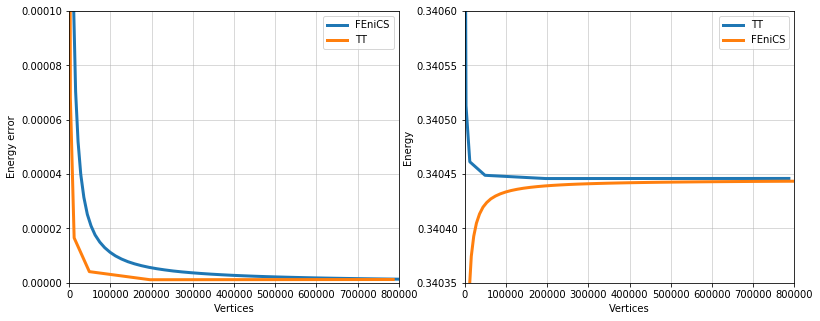

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
labels = []

labels.append(ax1.plot(fenics_vertices, [abs(e-answer) for e in fenics_energy], label="FEniCS", lw=3)[0])
labels.append(ax1.plot(tt_vertices, [abs(e-answer) for e in tt_energy], label="TT", lw=3)[0])

ax1.legend(handles=labels)
ax1.set_xlim([0, 800000])
ax1.set_ylim([0, 0.0001])

# ax1.set_xticks([0, 500000,1e6])
# ax1.set_xticklabels(['$0$', '$5e5$', '$1e6$'])
ax1.set_xlabel("Vertices")
ax1.set_ylabel("Energy error")
ax1.grid(alpha=0.6)

labels = []
labels.append(ax2.plot(tt_vertices, tt_energy, label="TT", lw=3)[0])
labels.append(ax2.plot(fenics_vertices, fenics_energy, label="FEniCS", lw=3)[0])
ax2.legend(handles=labels)
ax2.set_xlim([0, 800000])
ax2.set_ylim([0.34035, 0.3406])
# ax2.set_xticks([0, 500000,1e6])
# ax2.set_xticklabels(['$0$', '$5e5$', '$1e6$'])
ax2.set_xlabel("Vertices")
ax2.set_ylabel("Energy")
ax2.grid(alpha=0.6)

plt.show()

Converges! :)

From the right plot we can conclude that FEniCS gives the lower bound of solution and our approach gives the upper bound of solution.